# MSiA 423 - Cloud Engineering for Data Science - Final Project
## Group 7: Alejandra Lelo de Larrea Ibarra, Bannasorn Paspanthong, Ruben Nakano, Samuel Swain
# Modeling

In [2]:
# Libraries 
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import random
import math

from typing import Tuple

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
# --- Read csv file directly from the zip ---
archive = zipfile.ZipFile('../../02_Data/clean_data.zip', 'r')
files = archive.namelist()

# --- Load data sets --- 
with archive.open(files[0]) as csvfile:   
    df = pd.read_csv(csvfile)

In [4]:
# Look at the data
df.sample(10)

,book_date,airline,flight,class,departure_time,origin,duration,stops,arrival_time,destination,price
268799,22-03-2022,Vistara,UK-870,Economy,Night,Hyderabad,12.00,1,Morning,Kolkata,5960
44068,07-03-2022,Vistara,UK-810,Business,Early_Morning,Bangalore,13.08,1,Night,Mumbai,69244
218353,16-03-2022,Indigo,6E-6087,Economy,Evening,Kolkata,6.83,1,Late_Night,Delhi,2994
252025,31-03-2022,Indigo,6E-866,Economy,Afternoon,Hyderabad,5.17,1,Evening,Delhi,3397
242396,21-02-2022,Air India,AI-770,Economy,Night,Kolkata,16.17,1,Afternoon,Chennai,13524
14282,16-03-2022,Air India,AI-636,Business,Afternoon,Delhi,16.75,1,Early_Morning,Hyderabad,39321
251368,26-03-2022,Indigo,6E-2093,Economy,Morning,Hyderabad,2.25,0,Morning,Delhi,4873
290856,25-03-2022,Air India,AI-9894,Economy,Morning,Chennai,27.17,1,Morning,Bangalore,6714
294922,19-03-2022,Vistara,UK-828,Economy,Early_Morning,Chennai,26.67,1,Morning,Kolkata,7081
297915,03-03-2022,Air India,AI-430,Economy,Morning,Chennai,26.00,1,Morning,Hyderabad,3979


In [5]:
# --- Apply transformations based on EDA ---

# Drop column book_date
df.drop(['book_date'], axis=1, inplace=True)

# Drop airlines with less than 1000 flights
df = df.groupby('airline').filter(lambda x: len(x) > 1000)

# Log price
df['price'] = np.log(df['price'])

In [6]:
# Define the categorical and numerical features
cat_features = ['airline', 'flight', 'class', 'departure_time', 'origin', 'arrival_time', 'destination']
num_features = ['duration', 'stops']

In [7]:
# Preprocess data
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

In [13]:
preprocessor


ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['duration', 'stops']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['airline', 'flight', 'class',
                                  'departure_time', 'origin', 'arrival_time',
                                  'destination'])])

In [9]:
# Define the models
models = {
    'Linear Regression': (LinearRegression(), {}),
    'Random Forest': (RandomForestRegressor(random_state=423), {
        'model__n_estimators': [50, 200],
        'model__max_depth': [10],
        'model__min_samples_split': [10]
    }),
    'XGBoost': (XGBRegressor(random_state=423), {
        'model__n_estimators': [50, 200],
        'model__max_depth': [10],
        'model__learning_rate': [0.1]
    })
}

In [10]:
# Train and evaluate models with hyperparameter tuning
def train_and_evaluate(models: dict, X: pd.DataFrame, y: pd.Series) -> Tuple[dict, dict]:
    """
    This function trains and evaluates the models passed as a dictionary.

    Args:
        models (dict): Dictionary of models to train and evaluate.
        X (pandas.DataFrame): Features.
        y (pandas.Series): Target variable.

    Returns:
        results (dict): Dictionary of results.
        trained_models (dict): Dictionary of trained models.

    """
    
    # Initialize results and trained models dictionaries
    results = {}
    trained_models = {}

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=423)

    # Loop through models
    for name, (model, params) in models.items():

        # Create pipeline object
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

        # Fit the model depending on whether hyperparameter tuning is required
        if params:
            grid_search = GridSearchCV(pipeline, param_grid=params, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
        else:
            best_model = pipeline
            best_model.fit(X_train, y_train)

        # Predict on test set
        y_pred = best_model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Store results and trained models
        trained_models[name] = best_model
        results[name] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

        # Print results
        print(f'{name}:\nMSE: {mse}\nMAE: {mae}\nRMSE: {rmse}\nR2: {r2}\n')

    return results, trained_models

In [11]:
# Separate features and target
X = df.drop('price', axis=1)
y = df['price']

In [26]:
results, trained_models = train_and_evaluate(models, X, y)

Linear Regression:
MSE: 0.12097592224702512
MAE: 0.25947348195842784
RMSE: 0.34781593156010715
R2: 0.9023179361498223

Random Forest:
MSE: 0.12090032713776214
MAE: 0.25204871479732277
RMSE: 0.34770724343585674
R2: 0.9023789754554348

XGBoost:
MSE: 0.10652743729931209
MAE: 0.2365699417545137
RMSE: 0.32638541220359724
R2: 0.9139843719412266



In [31]:
import joblib

# Save the XGBoost model
xgboost_model_path = 'xgboost_model.pkl'
joblib.dump(trained_models['XGBoost'], xgboost_model_path)

# Save the preprocessor
preprocessor_path = 'preprocessor.pkl'
joblib.dump(preprocessor, preprocessor_path)

['preprocessor.pkl']

In [27]:
# Plot the comparison of the models
def plot_comparison(results: dict) -> None:
    """
    This function plots the comparison of the models based on the metrics.

    Args:
        results (dict): Dictionary containing the results of the models.
    """
    # Define variables
    model_names = list(results.keys())
    metrics = ['MSE', 'MAE', 'RMSE', 'R2']
    colors = ['blue', 'green', 'red']
    
    # Initialize subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    # Loop through metrics
    for i, metric in enumerate(metrics):
        metric_values = [model_result[metric] for model_result in results.values()]
        axes[i].bar(model_names, metric_values, color=colors, alpha=0.7)
        axes[i].set_title(f"Model Comparison ({metric})")
        axes[i].set_xlabel("Model")
        axes[i].set_ylabel(metric)
    
    plt.tight_layout()
    plt.show()

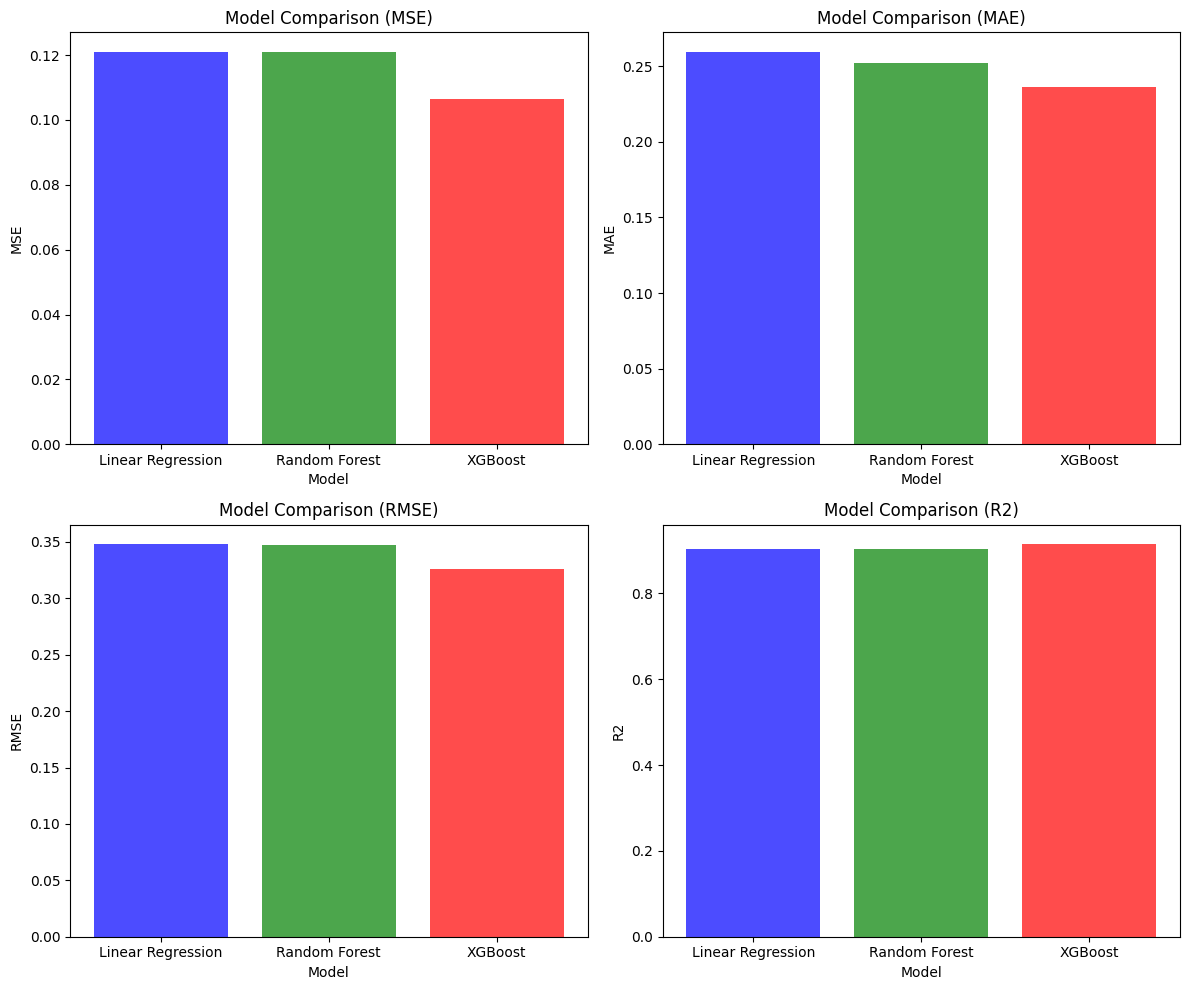

In [28]:
plot_comparison(results)

In [29]:
def display_sample_predictions(trained_models: dict, X_test: pd.DataFrame, y_test: pd.Series, n_samples: int) -> None:
    """
    This function displays the predictions of the models for a given number of samples.

    Args:
        trained_models (dict): Dictionary containing the trained models.
        X_test (pd.DataFrame): Test set features.
        y_test (pd.Series): Test set target.
        n_samples (int): Number of samples to display.

    """
    # Select random samples
    samples = random.sample(range(len(X_test)), n_samples)
    X_samples = X_test.iloc[samples]
    y_samples = y_test.iloc[samples]

    # Display predictions
    print("Sample Flights:")

    # Loop through samples
    for i, idx in enumerate(samples):
        print(f"\nSample {i + 1}:")
        print(f"Real price: {round(math.exp(y_samples.iloc[i]),0)}")

        # Loop through models
        for model_name, model in trained_models.items():
            y_pred = model.predict(X_samples.iloc[[i]])
            print(f"{model_name} predicted price: {round(math.exp(y_pred[0]),0)}")

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=423)
display_sample_predictions(trained_models, X_test, y_test, 4)

Sample Flights:

Sample 1:
Real price: 29776.0
Linear Regression predicted price: 32999.0
Random Forest predicted price: 31745.0
XGBoost predicted price: 35553.0

Sample 2:
Real price: 4387.0
Linear Regression predicted price: 4451.0
Random Forest predicted price: 4985.0
XGBoost predicted price: 5108.0

Sample 3:
Real price: 7112.0
Linear Regression predicted price: 6875.0
Random Forest predicted price: 6418.0
XGBoost predicted price: 6516.0

Sample 4:
Real price: 64139.0
Linear Regression predicted price: 52799.0
Random Forest predicted price: 57087.0
XGBoost predicted price: 56375.0
